In [1]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# 2. Load your dataset
df = pd.read_csv('/content/boiler_data.csv')

# 3. Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# 4. Handle missing values
# For numerical columns, fill missing values with the mean
num_imputer = SimpleImputer(strategy='mean')
df[df.select_dtypes(include=['float64', 'int64']).columns] = num_imputer.fit_transform(df.select_dtypes(include=['float64', 'int64']))

df = df.drop(columns=[
    "Power Consumption",
    "Vibration Sensor 1",
    "Vibration Sensor 2",
    "Operating Time",
    "Normal Operation Probability",
    "Blower Failure Probability",
    "Air Damper Failure Probability",
    "Gas Damper Failure Probability",
    "Probability Update Time",
    "Instantaneous Steam Amount",
    "Input-Output Efficiency",
    "Heat Loss Efficiency"
])


# For categorical columns, fill missing values with the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
df[df.select_dtypes(include=['object']).columns] = cat_imputer.fit_transform(df.select_dtypes(include=['object']))

# 5. Encode categorical variables (if any)
label_encoder = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])

# 6. Scale numerical features (optional, but good practice)
scaler = StandardScaler()
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# 7. Final preprocessed data
print(df.head())  # Display the first few rows of the preprocessed data


Missing values per column:
 Creation date                               0
load factor                                 0
Set Pressure                                0
Boiler Pressure                             0
Blower Inverter Output                      0
Blower Input                                0
Water Supply Pump                           0
Water Supply Pump Input                     0
Gas Damper                                  0
Gas Damper Input                            0
Air Damper                                  0
Air Damper Input                            0
Recirculation External Air Damper           0
Recirculation Damper Input                  0
Recirculation External Damper               0
Recirculation Damper Input.1                0
Recirculation External Damper Input         0
Water Supply Level                          0
Boiler Temperature                          0
Exhaust Gas Temperature 1                   0
Exhaust Gas Temperature 2                   0
Exhaus

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer


x_data = df.drop(columns=['Efficiency (Instantaneous)'])
y_data = df['Efficiency (Instantaneous)']

rf_model = RandomForestRegressor()

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

param_dist = {
    'n_estimators': np.arange(50, 1000, 50),
    'max_depth': np.arange(3, 50),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

# 랜덤 서치 설정
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=300,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 랜덤 서치 실행
random_search.fit(x_train, y_train)

y_pred = random_search.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'테스트 데이터 MSE: {mse}')
print(f'테스트 데이터 MAE: {mae}')
print(f'테스트 데이터 RMSE: {rmse}')
print(f'테스트 데이터 MAPE: {mape:.2f}%')

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
465 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
218 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py"

테스트 데이터 MSE: 0.10845834891388478
테스트 데이터 MAE: 0.04722139365075458
테스트 데이터 RMSE: 0.32933015184444436
테스트 데이터 MAPE: 45.16%


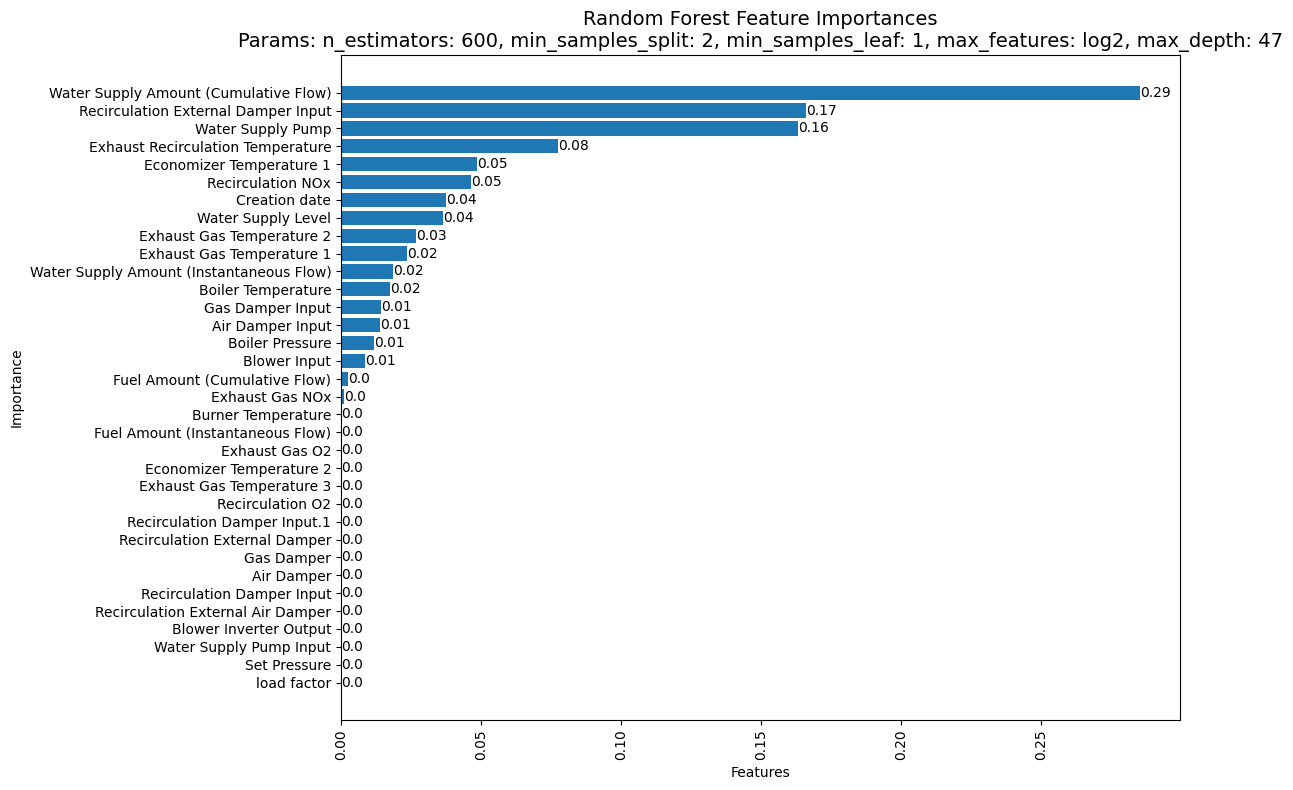

In [24]:
best_rf_model = random_search.best_estimator_

importances = best_rf_model.feature_importances_
importance_name = best_rf_model.feature_names_in_

best_params = random_search.best_params_
best_params_str = ', '.join([f'{key}: {value}' for key, value in best_params.items()])

import matplotlib.pyplot as plt

sorted_idx = np.argsort(importances)
sorted_importances = importances[sorted_idx]
sorted_features = importance_name[sorted_idx]

plt.figure(figsize=(12, 8))
bars = plt.barh(sorted_features, sorted_importances)  # 세로 막대 그래프
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title(f'Random Forest Feature Importances\nParams: {best_params_str}', fontsize=14)
plt.tight_layout()

for bar in bars:
    width = bar.get_width()  # 막대 높이 (즉, 값)
    plt.text(width, bar.get_y() + bar.get_height()/2, round(width, 2), ha='left', va='center')

plt.show()